<a href="https://colab.research.google.com/github/JackSolano/Topicos-Estadisticas/blob/main/sintitulo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import files # Para cargar archivos en google colab

import pandas as pd  # Pandas: Manipulación y análisis de datos con estructuras como DataFrame.
import numpy as np  # NumPy: Soporte para arrays y operaciones matemáticas de alto rendimiento.
import io # Io:
import matplotlib.pyplot as plt  # Matplotlib: Visualización de datos, gráficos y figuras.

from sklearn.model_selection import train_test_split  # Divide los datos en conjunto de entrenamiento y prueba.
from sklearn.preprocessing import StandardScaler  # Estandariza los datos para que tengan media 0 y varianza 1.
from sklearn.neural_network import MLPRegressor  # Implementa una red neuronal para tareas de regresión.
from sklearn import metrics  # Métricas de evaluación como MSE, MAE, R2, etc.
from sklearn.model_selection import GridSearchCV  # Búsqueda de hiperparámetros óptimos mediante validación cruzada.

from sklearn.ensemble import RandomForestClassifier # Opcion a
from sklearn.naive_bayes import GaussianNB #Opcion b

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

import pylab as pl
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
uploaded = files.upload()

Saving D. MENORES.txt to D. MENORES (3).txt


In [11]:
datos_menores = pd.read_csv(io.BytesIO(uploaded['D. MENORES (3).txt']), delimiter='\t')
datos_menores.head(4)

,Directorio,Nro_encuesta,Secuencia_encuesta,Secuencia_p,Orden,P51,P52,P52s1,P53,P54,...,P8582s3,P8582s4,P8582s11,P8582s6,P8582s7,P8582s9,P8582s12,P8582s10,P8582s10a1,Fex_c
0,447,247,4,1,4,4,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1454.129389
1,17255,247,3,1,3,1,NaN,NaN,1.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,663.046128
2,373,247,5,1,5,1,NaN,NaN,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1925.021859
3,373,247,4,1,4,1,NaN,NaN,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1925.021859


# **Objetivo del análisis:**

El objetivo principal es identificar los factores asociados a la asistencia de los menores a controles de crecimiento y desarrollo (P6161).

Para ello, se han seleccionado variables relacionadas con:
- El tipo de cuidado que recibe el menor.
- Las razones por las que no asiste a educación inicial.
- Sus hábitos alimenticios (desayuno, almuerzo, onces).
- El involucramiento de los padres en actividades con ellos.

Mediante la construcción de un modelo predictivo (como regresión logística o árbol de decisión), se busca:
- Determinar qué factores tienen mayor impacto en la asistencia a controles.
- Predecir si un menor asistirá o no a controles con base en sus condiciones familiares y sociales.


**Limpiar datos**

In [12]:
datos_menores.P52.isnull()

datos_menores.loc[datos_menores.P52.notnull(), "P52"] # Tomé la columna P52 y las filas donde esta no tiene valores faltantes

tabla = datos_menores.loc[datos_menores.P52.notnull(), ["P51", "P52", "P55", "P56", "P57", "P6159s8",
                                                        "P6163s8", "P6161", "P6161s1"]]
# Tomé la columnas "P51", "P52", "P55", "P56", "P57", "P6159s8", "P6163s8", "P6161", "P6161s1"  y
# las filas donde esta no tiene valores faltantes para P52
tabla.head(3)

tabla.P6159s8.isnull() # Las madres que hacen alguna actividad con los menores
tabla.loc[tabla.P6159s8.isnull(), "P6159s8"] = 2 # 2 denota las madres que sí hacen actividades con los hijos
tabla.P6163s8.isnull() # Los padres que hacen alguna actividad con los menores
tabla.loc[tabla.P6163s8.isnull(), "P6163s8"] = 2 # 2 denota los padres que sí hacen actividades con los hijos


tabla.P6163s8.value_counts()
tabla.head(3)

,P51,P52,P55,P56,P57,P6159s8,P6163s8,P6161,P6161s1
0,4,5.0,1,1,1,2.0,2.0,1,6.0
4,2,5.0,1,1,1,2.0,2.0,1,3.0
5,2,5.0,1,1,1,1.0,1.0,1,1.0


**Convertir variables a Dummies**

In [13]:
dummi_menores = pd.get_dummies(tabla, columns=["P51", "P52", "P55", "P56", "P57", "P6159s8", "P6163s8"], dtype = float)
dummi_menores.head(5)
dummi_menores.columns
dummi_menores.rename(columns = {'P51_2':'acu casa', 'P51_3':'acu trab', 'P51_4':'niñera', 'P51_5':"mayor", 'P51_6':"menor", 'P51_7':"solo", 'P51_8':"otra persona"}, inplace = True)
dummi_menores.rename(columns = {'P52_1.0':"lejos", 'P52_2.0':"costoso", 'P52_3.0':"sin cupo", 'P52_4.0':"casa", 'P52_5.0':"edad", 'P52_6.0':"otro motivo"}, inplace = True)
dummi_menores.rename(columns = {'P55_1':"si desa", 'P55_2':"no desa", 'P56_1':"si alm", 'P56_2':"no alm", 'P57_1':"si onces", 'P57_2':"no onces"}, inplace = True)
dummi_menores.rename(columns = {'P6159s8_1.0':"no comp madre", 'P6159s8_2.0':"si comp madre", 'P6163s8_1.0':"no comp padre", 'P6163s8_2.0':"si comp padre"}, inplace = True)
dummi_menores.head(5)


,P6161,P6161s1,acu casa,acu trab,niñera,mayor,menor,solo,otra persona,lejos,...,si desa,no desa,si alm,no alm,si onces,no onces,no comp madre,si comp madre,no comp padre,si comp padre
0,1,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,1,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
5,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
6,1,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
7,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


**Variables explicativas (X):**

    acu casa        = El niño/a se queda con un acompañante en casa
    acu trab        = El niño/a acompaña a la madre al trabajo
    niñera          = Lo cuida una niñera
    mayor           = Lo cuida un hermano/a mayor
    menor           = Lo cuida un hermano/a menor
    solo            = Se queda solo/a
    otra persona    = Lo cuida otra persona distinta

    lejos           = No asiste a educación inicial porque el lugar está lejos
    costoso         = No asiste porque es costoso
    sin cupo        = No asiste porque no hay cupo
    casa            = No asiste porque la madre prefiere que se quede en casa
    edad            = No asiste por la edad del menor
    otro motivo     = No asiste por otro motivo

    si desa         = Sí desayuna
    no desa         = No desayuna
    si alm          = Sí almuerza
    no alm          = No almuerza
    si onces        = Sí toma onces
    no onces        = No toma onces

    si comp madre   = La madre comparte actividades con el niño/a
    no comp madre   = La madre no comparte actividades con el niño/a
    si comp padre   = El padre comparte actividades con el niño/a
    no comp padre   = El padre no comparte actividades con el niño/a

**Variable dependiente (y):**

    P6161           = Indicador de si el niño/a asiste a controles de crecimiento y desarrollo
                    Valores:
                    - "Si" = Asiste
                    - "No" = No asiste


In [16]:
x = dummi_menores.drop(["P6161", 'P6161s1'], axis = 1) # Acá tomo todas las variables explicativas: todas las variables menos P6161, la cual me denota si el menor recibe
# control de crecimiento y desarrollo
y = dummi_menores["P6161"].astype(str) # Variable de salida: P6161 (si el menor recibe controles de crecimiento y desarrollo)
y.loc[(y == "1")] = "Si"
y.loc[(y == "2")] = "No"
y.value_counts()

,count
P6161,
Si,2210
No,514


## Separar datos de entrenamiento

In [17]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(x, y, test_size = 0.2)

hidden_layers = tuple([int(2.98**i) for i in range(4, 9)])
print(hidden_layers)

(78, 235, 700, 2086, 6219)


## **MLP Classifier**

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Definir arquitectura de la red
hidden_layers = tuple([int(2.98**i) for i in range(4, 9)])

# Inicializar y entrenar el modelo
mlp_clf = MLPClassifier(
    alpha=1e-7,
    batch_size=70,
    hidden_layer_sizes=hidden_layers,
    max_iter=800,
    activation='relu',
    solver='adam'
)

mlp_clf.fit(trainX, trainY)

# Predicciones
y_pred = mlp_clf.predict(testX)

# Evaluación: Accuracy
accuracy = accuracy_score(testY, y_pred)
print('Accuracy del MLPClassifier: {:.2f}'.format(accuracy))

# Matriz de confusión
cm = confusion_matrix(testY, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Reales')
plt.title('Matriz de Confusión - MLPClassifier')
plt.show()

# Curva de pérdida
losses = mlp_clf.loss_curve_
plt.figure(figsize=(7, 4))
plt.plot(losses, label='Loss')
plt.title("Curva de Pérdida - MLPClassifier", fontsize=14)
plt.xlabel('Iteraciones')
plt.ylabel('Costo')
plt.legend()
plt.grid(True)
plt.show()

# Encontrar automáticamente el mínimo de pérdida en el último 20% de las iteraciones
window = int(0.2 * len(losses))  # último 20% de iteraciones
start = len(losses) - window if window > 0 else 0
losses_interval = losses[start:]
if losses_interval:
    min_index = np.argmin(losses_interval) + start
    min_value = losses[min_index]
    print(f"Mínimo de pérdida en el último {window} iteraciones:")
    print(f"Iteración: {min_index}, Pérdida: {min_value:.4f}")
else:
    print("No se pudo calcular el mínimo de pérdida: la curva está vacía o muy corta.")


(78, 235, 700, 2086, 6219)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(alpha=1e-07, batch_size=70,
              hidden_layer_sizes=(78, 235, 700, 2086, 6219), max_iter=800)

## Porcentaje de explicacion

In [ ]:
y_pred = mlp_clf.predict(testX)
from sklearn.metrics import accuracy_score
print('Accuracy: {:.2f}'.format(accuracy_score(y_pred, testY))) # El modelo no presenta ni underfitting ni overfitting

Accuracy: 0.82


## Matriz de confusion

Text(0.5, 1.0, 'Confusion Matrix')

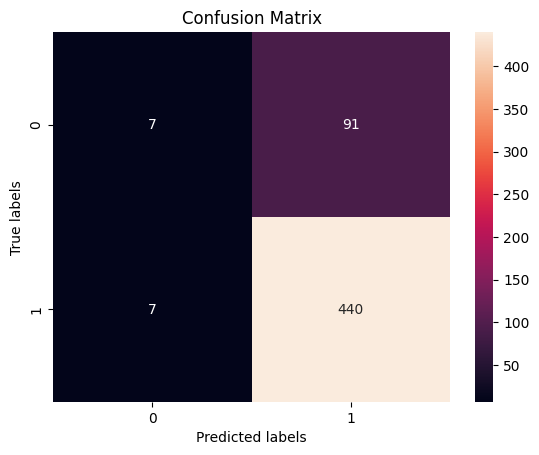

In [ ]:
cm = confusion_matrix(testY, y_pred)
cm
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix')

## Curva de perdida

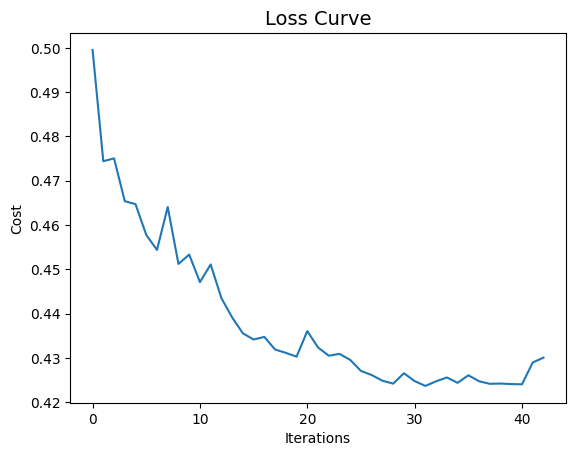

In [ ]:
plt.plot(mlp_clf.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

## Minimo Costo


In [ ]:
# Definir el intervalo
start = 50
end = 100
losses = mlp_clf.loss_curve_

# Aseguramos que el intervalo esté dentro del tamaño de la curva de pérdida


# Extraemos las pérdidas en el intervalo
losses_interval = losses[start:end]

# Si el intervalo no está vacío, buscamos el mínimo
if len(losses_interval) > 0:
    min_index = np.argmin(losses_interval) + start
    min_value = losses[min_index]
    print(f"Mínimo en el intervalo [{start}, {end}]:")
    print(f"Iteración: {min_index}, Pérdida: {min_value:.4f}")
else:
    print(f"El intervalo [{start}, {end}] está fuera del rango de la curva de pérdida.")



El intervalo [50, 100] está fuera del rango de la curva de pérdida.


# **Random Forest**  

Random Forest Accuracy: 0.84


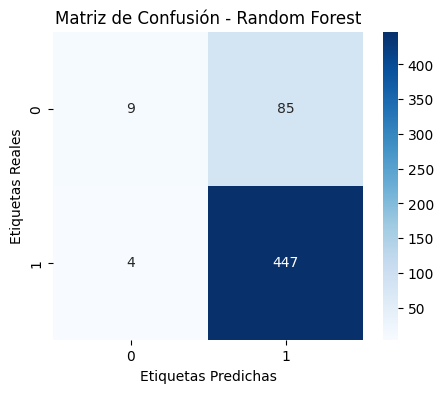

In [18]:
# Entrenar modelo Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(trainX, trainY)

# Predicciones
rf_pred = rf_clf.predict(testX)

# Evaluación
print("Random Forest Accuracy: {:.2f}".format(accuracy_score(testY, rf_pred)))

# Matriz de confusión
cm_rf = confusion_matrix(testY, rf_pred)

# Visualización
plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='g', cmap='Blues')
plt.title('Matriz de Confusión - Random Forest')
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Reales')
plt.show()

# **Gaussian Naive Bayes**

GaussianNB Accuracy: 0.74


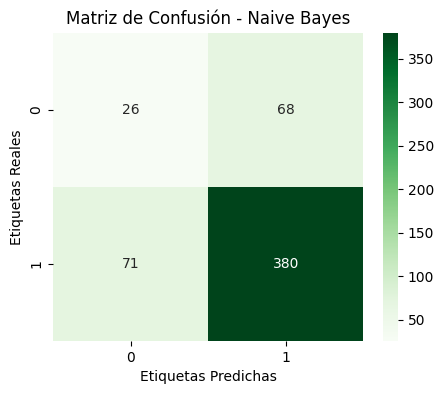

In [19]:
# Crear y entrenar el clasificador Naive Bayes
nb_clf = GaussianNB()
nb_clf.fit(trainX, trainY)

# Realizar predicciones
nb_pred = nb_clf.predict(testX)

# Evaluar el modelo
accuracy_nb = accuracy_score(testY, nb_pred)
print("GaussianNB Accuracy: {:.2f}".format(accuracy_nb))

# Matriz de confusión
cm_nb = confusion_matrix(testY, nb_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(5,4))
sns.heatmap(cm_nb, annot=True, fmt='g', cmap='Greens')
plt.title('Matriz de Confusión - Naive Bayes')
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Reales')
plt.show()
